In [2]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath(".")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
import mrcnn_utils
import model as modellib
import visualize
# Import COCO config
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    mrcnn_utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

/home/gun/anaconda3/envs/py3_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/gun/anaconda3/envs/py3_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/gun/anaconda3/envs/py3_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/gun/anaconda3/envs/py3_gpu/lib/python3.6/site-

In [3]:
sys.path.append(os.path.join(ROOT_DIR, '..', 'dqn_image'))
from backgroundsubtraction_module import BackgroundSubtraction

backsub = BackgroundSubtraction()

In [61]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [62]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
tf_config = tf.ConfigProto()
tf_config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=tf_config))

In [63]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [64]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Run Object Detection

Processing 1 images
image                    shape: (476, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  119.30000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32



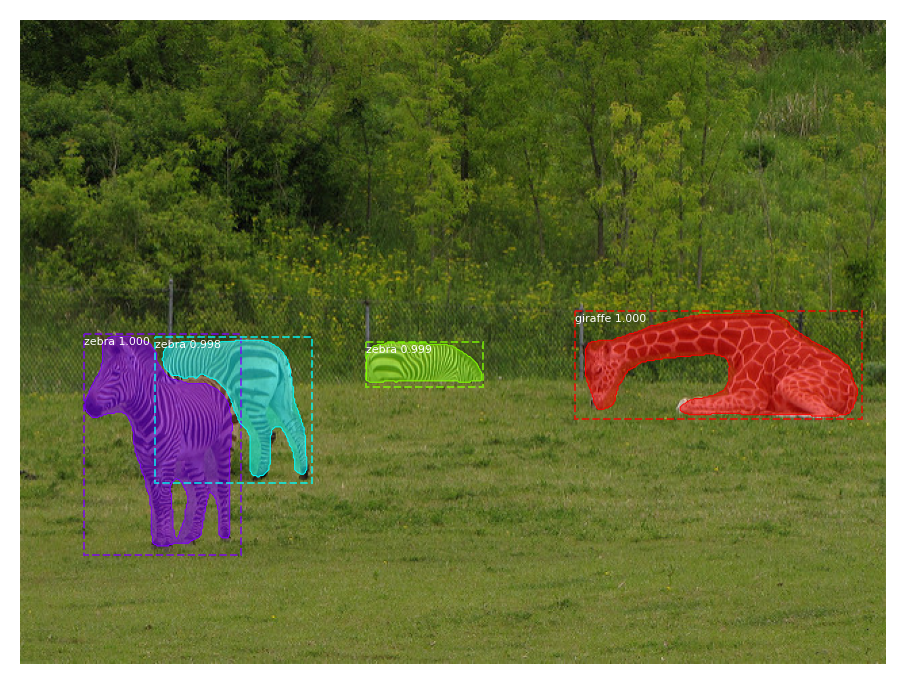

In [7]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [7]:
image.shape

(426, 640, 3)

In [8]:
r['feature_maps'].shape

(7, 32, 256)

In [9]:
r['feature_maps'].max(1).shape

(7, 256)

In [10]:
r['scores']

array([0.99926156, 0.9984444 , 0.9974631 , 0.9744091 , 0.95906776,
       0.82293755, 0.77324986], dtype=float32)

person
person


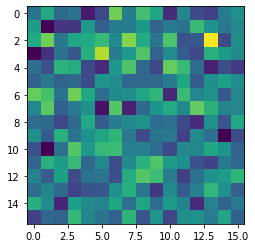

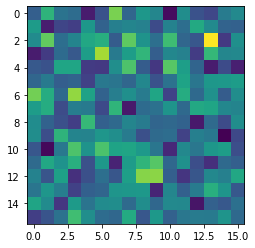

35.878323


In [11]:
o1, o2 = 0, 1
print(class_names[r['class_ids'][o1]])
print(class_names[r['class_ids'][o2]])
plt.imshow(r['feature_maps'].max(1)[o1].reshape(16,-1))
plt.show()
plt.imshow(r['feature_maps'].max(1)[o2].reshape(16,-1))
plt.show()
print(np.linalg.norm(r['feature_maps'].max(1)[o1] - r['feature_maps'].max(1)[o2]))

person
snowboard


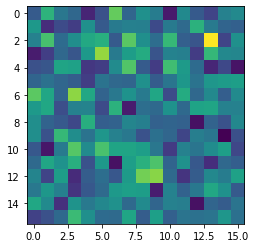

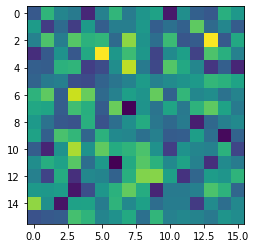

26.625845


In [21]:
o1, o2 = 2, 4
print(class_names[r['class_ids'][o1]])
print(class_names[r['class_ids'][o2]])
plt.imshow(r['feature_maps'].max(1)[o1].reshape(16,-1))
plt.show()
plt.imshow(r['feature_maps'].max(1)[o2].reshape(16,-1))
plt.show()
print(np.linalg.norm(r['feature_maps'].max(1)[o1] - r['feature_maps'].max(1)[o2]))

In [22]:
r['feature_maps'].max(1)[0,:].shape

(256,)

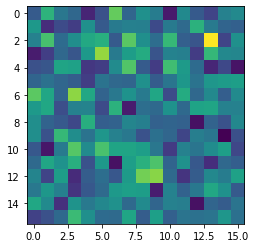

In [23]:
plt.imshow(r['feature_maps'].max(1)[o1].reshape(16,-1))
plt.show()

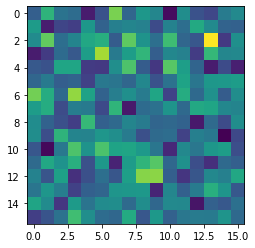

In [24]:
plt.imshow(r['feature_maps'].max(1)[1].reshape(16,-1))

In [25]:
len(r['scores'])

7

In [8]:
from sklearn.cluster import SpectralClustering

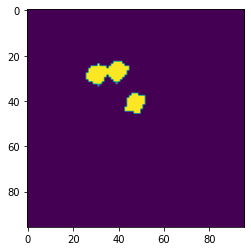

In [57]:
image = np.load('../dqn_image/seg_fault.npy').astype(np.uint8)
m, c, fm, ct = backsub.get_masks(image)
plt.imshow(fm)

/home/gun/anaconda3/envs/py3_gpu/lib/python3.6/site-packages/sklearn/cluster/_spectral.py:484: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
/home/gun/anaconda3/envs/py3_gpu/lib/python3.6/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


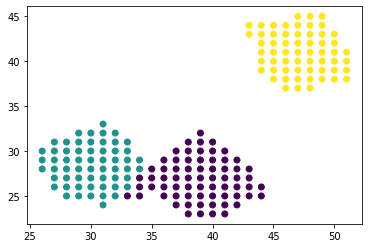

In [56]:
x = SpectralClustering(n_clusters=3, n_init=10).fit_predict(fm)

my, mx = np.nonzero(fm)
points = list(zip(mx, my, np.ones_like(mx) * 96))
z = (np.array(points).T / np.linalg.norm(points, axis=1)).T
x = SpectralClustering(n_clusters=3, n_init=10).fit_predict(z)

plt.scatter(mx, my, c=x)

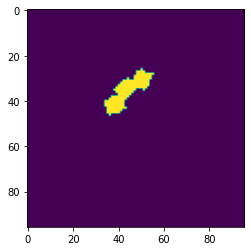

In [58]:
image = np.load('../dqn_image/seg_fault2.npy').astype(np.uint8)
m, c, fm, ct = backsub.get_masks(image)
plt.imshow(fm)

/home/gun/anaconda3/envs/py3_gpu/lib/python3.6/site-packages/sklearn/cluster/_spectral.py:484: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
/home/gun/anaconda3/envs/py3_gpu/lib/python3.6/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


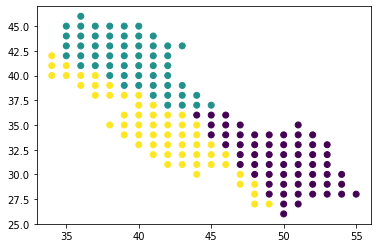

In [59]:
x = SpectralClustering(n_clusters=3, n_init=10).fit_predict(fm)

my, mx = np.nonzero(fm)
points = list(zip(mx, my, np.ones_like(mx) * 96))
z = (np.array(points).T / np.linalg.norm(points, axis=1)).T
x = SpectralClustering(n_clusters=3, n_init=10).fit_predict(z)

plt.scatter(mx, my, c=x)

Processing 1 images
image                    shape: (96, 96, 3)           min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


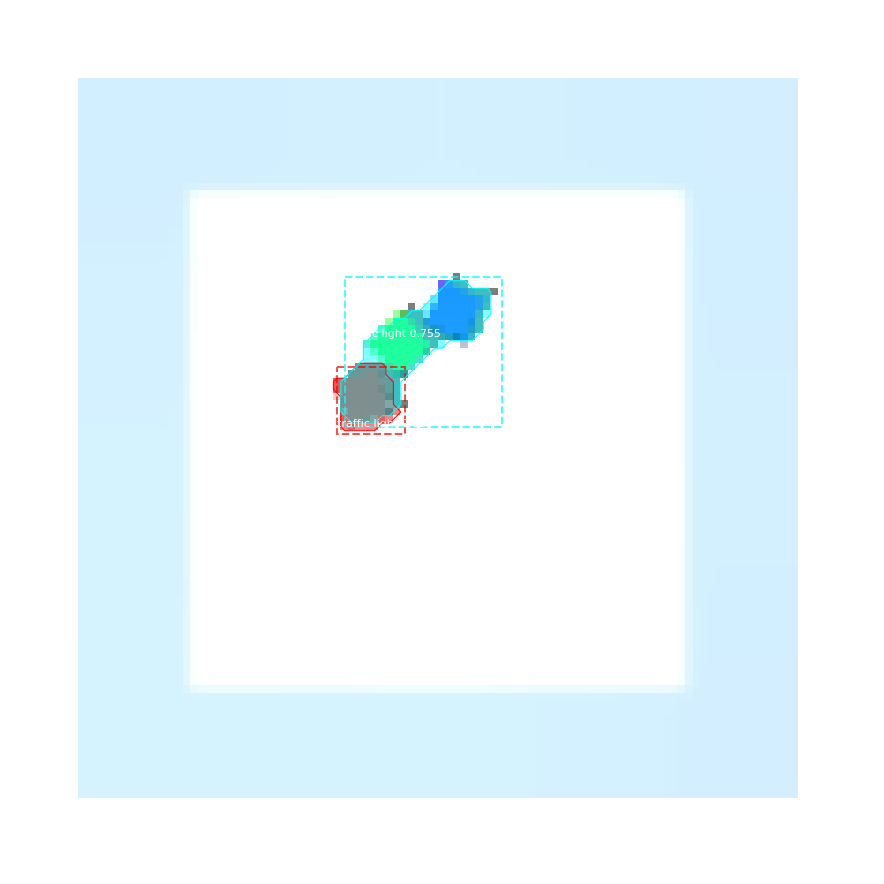

In [69]:
pad = 10
image = np.pad(image[pad:-pad, pad:-pad], [[pad,pad],[pad,pad], [0, 0]], 'edge')
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

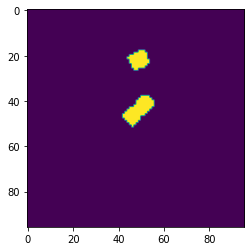

In [71]:
image = np.load('../dqn_image/seg_fault3.npy').astype(np.uint8)
m, c, fm, ct = backsub.get_masks(image)
plt.imshow(fm)

/home/gun/anaconda3/envs/py3_gpu/lib/python3.6/site-packages/sklearn/cluster/_spectral.py:484: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
/home/gun/anaconda3/envs/py3_gpu/lib/python3.6/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


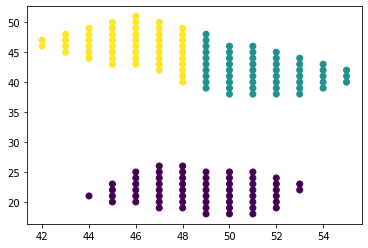

In [72]:
x = SpectralClustering(n_clusters=3, n_init=10).fit_predict(fm)

my, mx = np.nonzero(fm)
points = list(zip(mx, my, np.ones_like(mx) * 96))
z = (np.array(points).T / np.linalg.norm(points, axis=1)).T
x = SpectralClustering(n_clusters=3, n_init=10).fit_predict(z)

plt.scatter(mx, my, c=x)

In [70]:
r['scores']

array([0.8251009, 0.7547552], dtype=float32)

In [20]:
fm.max()

255

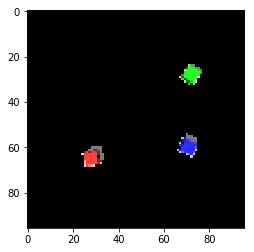

In [15]:
new_image = np.zeros_like(image)
new_image[fm.astype(bool)] = image[fm.astype(bool)]
plt.imshow(new_image)

Processing 1 images
image                    shape: (96, 96, 3)           min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


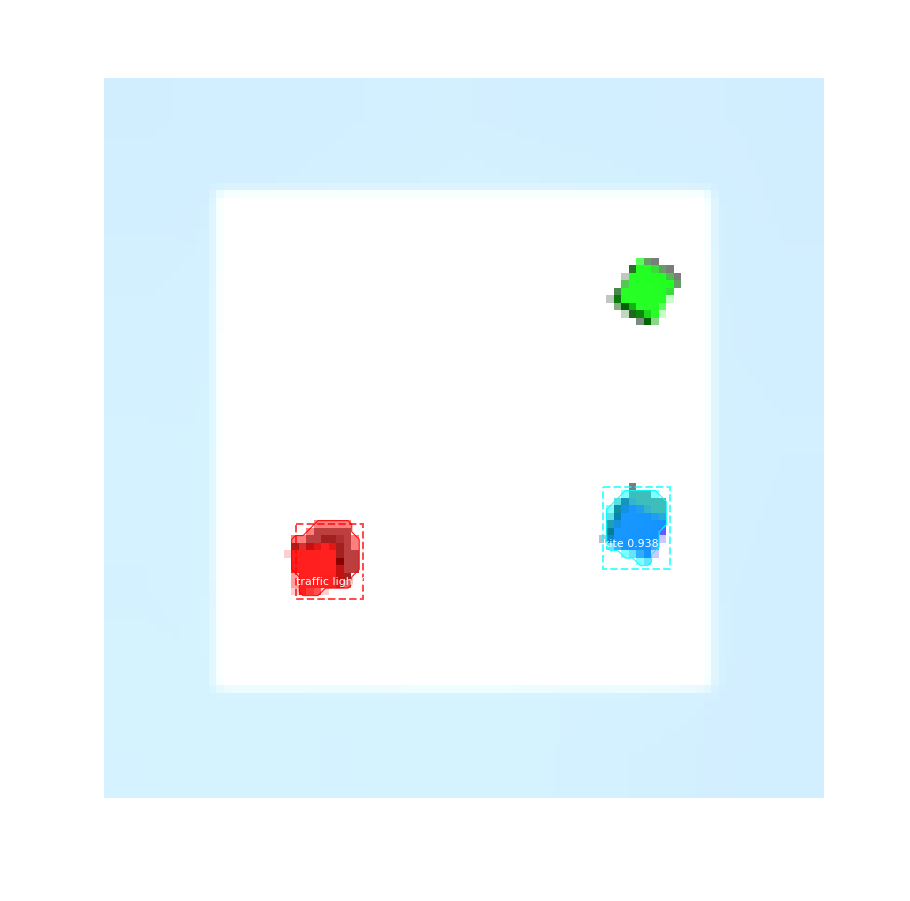

In [43]:
# Load a random image from the images folder
image = skimage.io.imread('../ur5_mujoco/test.png')
image = np.pad(image[pad:-pad, pad:-pad], [[pad,pad],[pad,pad], [0, 0]], 'edge')

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

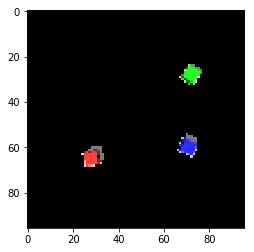

Processing 1 images
image                    shape: (96, 96, 3)           min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


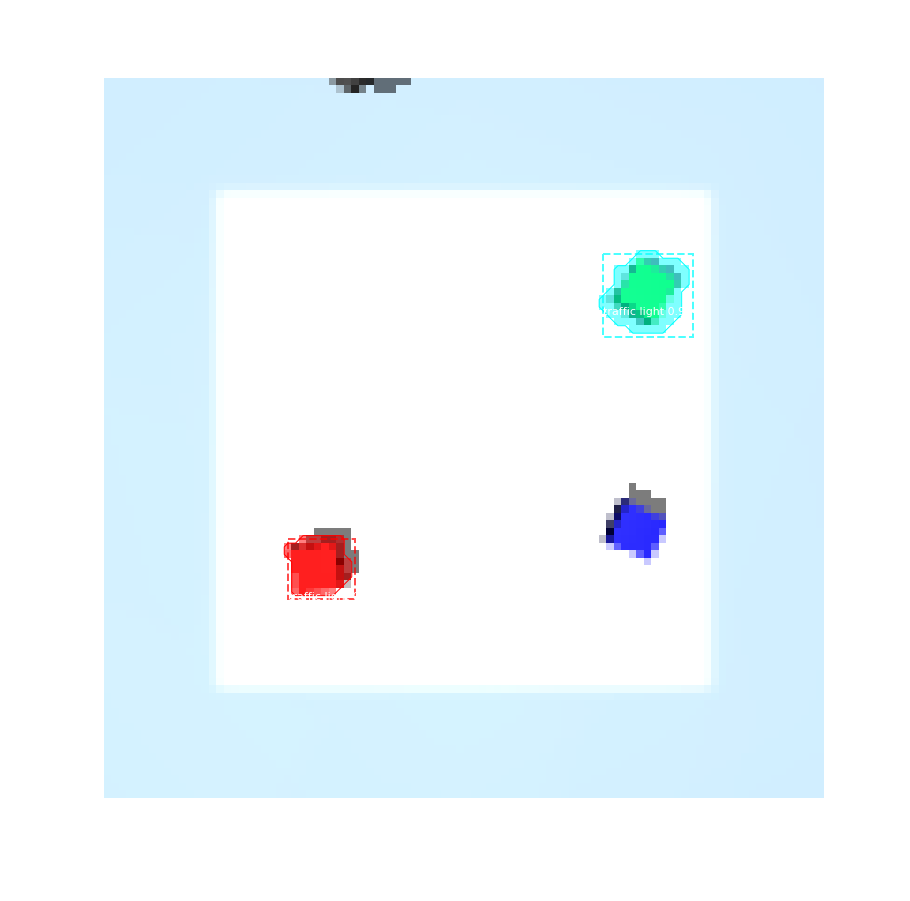

In [40]:
# Load a random image from the images folder
image = skimage.io.imread('../ur5_mujoco/test.png')

# get masks
m, c, fm, ct = backsub.get_masks(image)
new_image = np.zeros_like(image)
new_image[fm.astype(bool)] = image[fm.astype(bool)]
plt.imshow(new_image)
plt.show()

# Run detection
black = model.detect([new_image], verbose=1)

# Visualize results
r = black[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

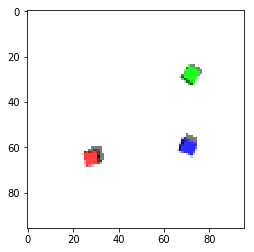

Processing 1 images
image                    shape: (96, 96, 3)           min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


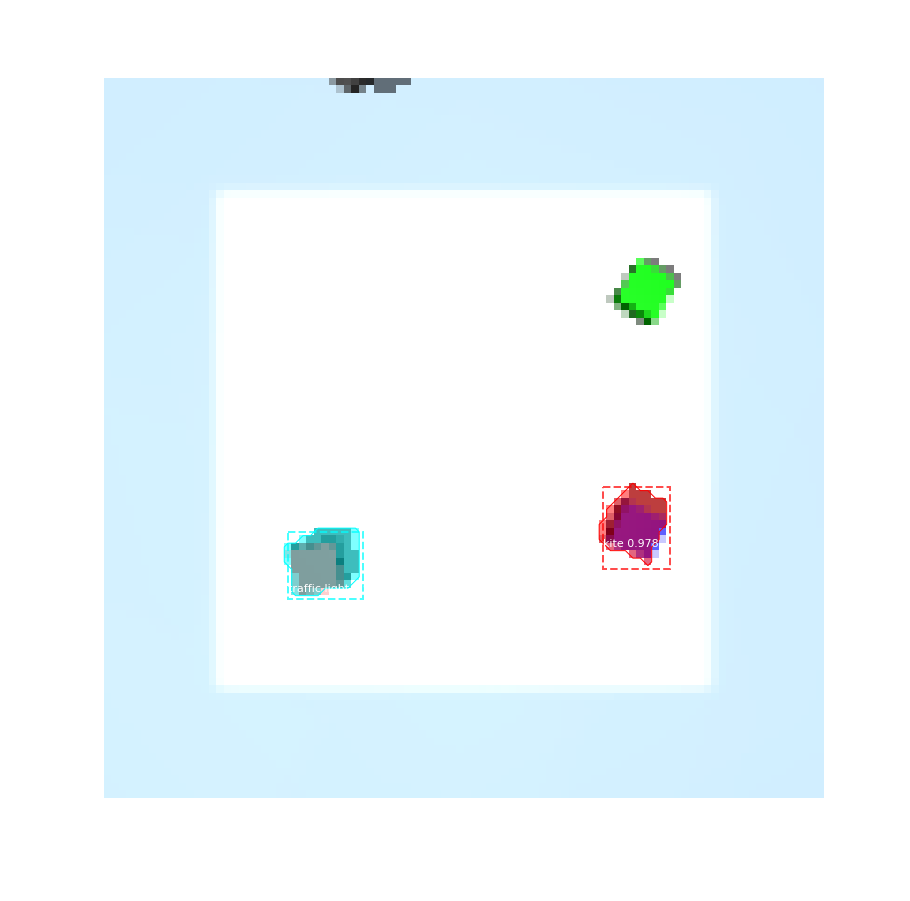

In [41]:
# Load a random image from the images folder
image = skimage.io.imread('../ur5_mujoco/test.png')

# get masks
m, c, fm, ct = backsub.get_masks(image)
new_image = np.ones_like(image) * 255
new_image[fm.astype(bool)] = image[fm.astype(bool)]
plt.imshow(new_image)
plt.show()

# Run detection
white = model.detect([new_image], verbose=1)

# Visualize results
r = white[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

Processing 1 images
image                    shape: (96, 96, 3)           min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


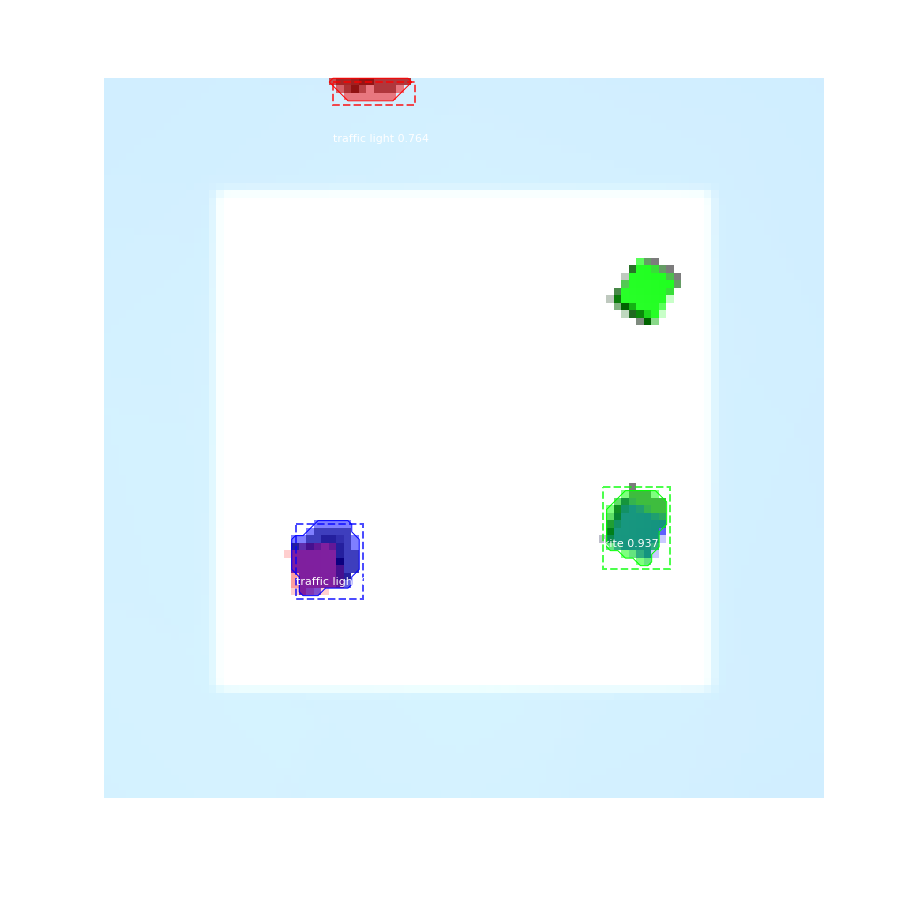

In [9]:
# Load a random image from the images folder
image = skimage.io.imread('../ur5_mujoco/test.png')

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [49]:
black[0]['scores']

array([0.97361517, 0.86481744], dtype=float32)

In [50]:
white[0]['scores']

array([0.99068063, 0.9779984 ], dtype=float32)

In [55]:
black[0]['masks'].shape

(96, 96, 2)

In [62]:
mask_black = []
color_black = []
for i in range(black[0]['masks'].shape[-1]):
    fmask = black[0]['masks'][:,:,i].astype(np.uint8)
    contours, hierarchy = cv2.findContours(fmask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    masks, colors = [], []
    num_seg = len(contours)
    for ns in range(num_seg):
        zeros = np.zeros_like(fmask)
        obj_mask = cv2.drawContours(zeros, contours, ns, 1, -1)
        obj_color = image[obj_mask.astype(bool)].mean(0)/255.
        mask_black.append(obj_mask)
        color_black.append(obj_color)

In [66]:
mask_white = []
color_white = []
for i in range(white[0]['masks'].shape[-1]):
    fmask = white[0]['masks'][:,:,i].astype(np.uint8)
    contours, hierarchy = cv2.findContours(fmask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    masks, colors = [], []
    num_seg = len(contours)
    for ns in range(num_seg):
        zeros = np.zeros_like(fmask)
        obj_mask = cv2.drawContours(zeros, contours, ns, 1, -1)
        obj_color = image[obj_mask.astype(bool)].mean(0)/255.
        mask_white.append(obj_mask)
        color_white.append(obj_color)

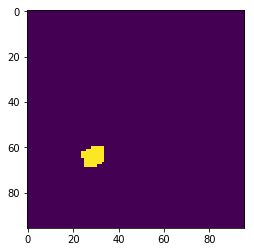

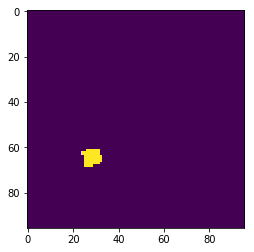

76
57


In [77]:
mb = mask_black[1]
mw = mask_white[0]

mask_union = np.any([mb, mw], 0)
mask_intersection = np.all([mb, mw], 0)
plt.imshow(mask_union)
plt.show()
plt.imshow(mask_intersection)
plt.show()
print(mask_union.sum())
print(mask_intersection.sum())

In [ ]:
for mb in mask_black:
    for mw in mask_white:
        mask_union = np.any([mb, mw], 0)
        mask_intersection = np.all([mb, mw], 0)
        if mask_intersection.sum() / mask_union.sum() > 0.5:
            # is same mask
            mask_select = mb if mb.sum() < mw.sum() else mw

In [90]:
mask_list = sorted(mask_black + mask_white, key=lambda m: m.sum())
mask_selected = [mask_list[0]]

for mask in mask_list[1:]:
    check_duplicate = False
    for idx, ms in enumerate(mask_selected):
        mask_union = np.any([mask, ms], 0)
        mask_intersection = np.all([mask, ms], 0)
        if mask_intersection.sum() / mask_union.sum() > 0.5:
            check_duplicate = True
            if mask.sum() < ms.sum():
                mask_selected[idx] = mask
    if not check_duplicate:
        mask_selected.append(mask)        

In [ ]:

        masks = []
        colors = []
        feature_maps = []
        for m in range(len(seg_result['scores'])):
            mask = seg_result['masks'][:,:,m].astype(np.float32)
            if scale_on:
                mask_rgb = np.stack([mask] * 3)
                mask_rgb = mask_rgb.transpose([1, 2, 0])
                mask_resized = cv2.resize(mask_rgb, (0, 0), fx=1/self.scale, fy=1/self.scale)
                mask = mask_resized[:,:,0]
            masks.append(mask)

            color = image[mask.astype(bool)].mean(0)/255.
            colors.append(color)

            feature_map = seg_result['feature_maps'].max(1)[m]
            feature_maps.append(feature_map)


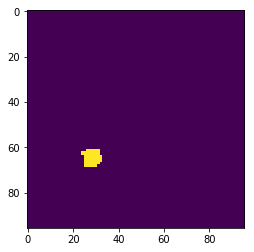

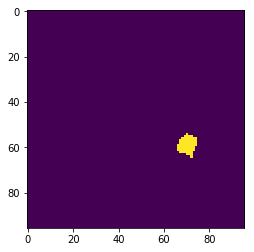

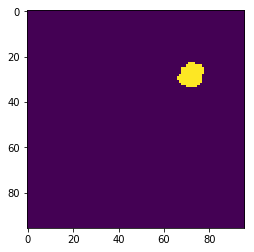

In [93]:
for m in mask_selected:
    plt.imshow(m)
    plt.show()

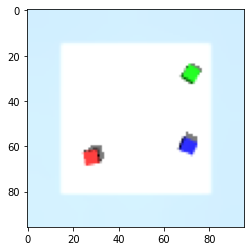

In [56]:
pad = 5
x = np.pad(image[pad:-pad, pad:-pad], [[pad,pad],[pad,pad], [0, 0]], 'edge')
plt.imshow(x)

Processing 1 images
image                    shape: (192, 192, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


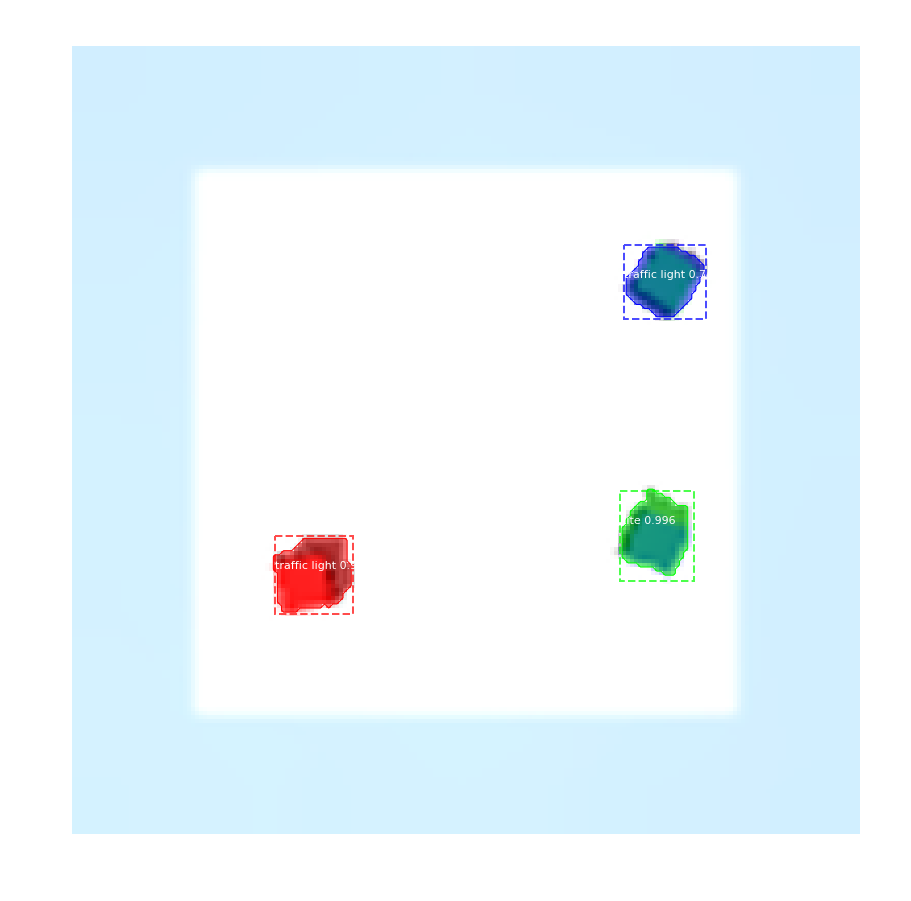

In [38]:
import cv2

# Load a random image from the images folder
image = skimage.io.imread('../ur5_mujoco/test.png')
pad = 5
image = np.pad(image[pad:-pad, pad:-pad], [[pad,pad],[pad,pad], [0, 0]], 'edge')

scale = 2
height, width = image.shape[:2]
# im_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# get masks
m, c, fm, ct = backsub.get_masks(image)
new_image = np.ones_like(image) * 255
new_image[fm.astype(bool)] = image[fm.astype(bool)]

im_large = cv2.resize(image, (width*scale, height*scale), interpolation=cv2.INTER_CUBIC)
new_im_large = cv2.resize(new_image, (width*scale, height*scale), interpolation=cv2.INTER_CUBIC)

# Run detection
results = model.detect([new_im_large], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(im_large, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

Processing 1 images
image                    shape: (192, 192, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


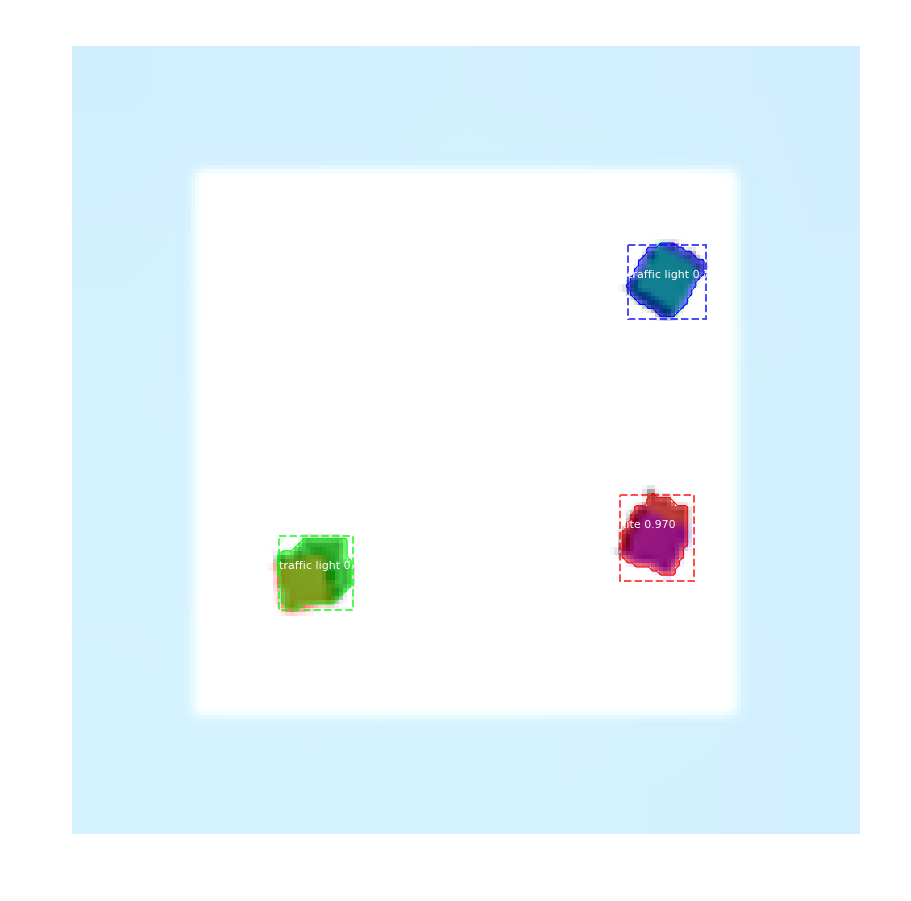

In [39]:
import cv2

# Load a random image from the images folder
image = skimage.io.imread('../ur5_mujoco/test.png')
pad = 5
image = np.pad(image[pad:-pad, pad:-pad], [[pad,pad],[pad,pad], [0, 0]], 'edge')

scale = 2
height, width = image.shape[:2]
# im_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
im_large = cv2.resize(image, (width*scale, height*scale), interpolation=cv2.INTER_CUBIC)

# Run detection
results = model.detect([im_large], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(im_large, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

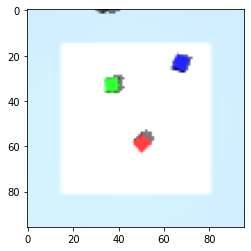

In [31]:
image = (np.load('tim.npy') * 255).astype(np.uint8)
plt.imshow(image)

Processing 1 images
image                    shape: (288, 288, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


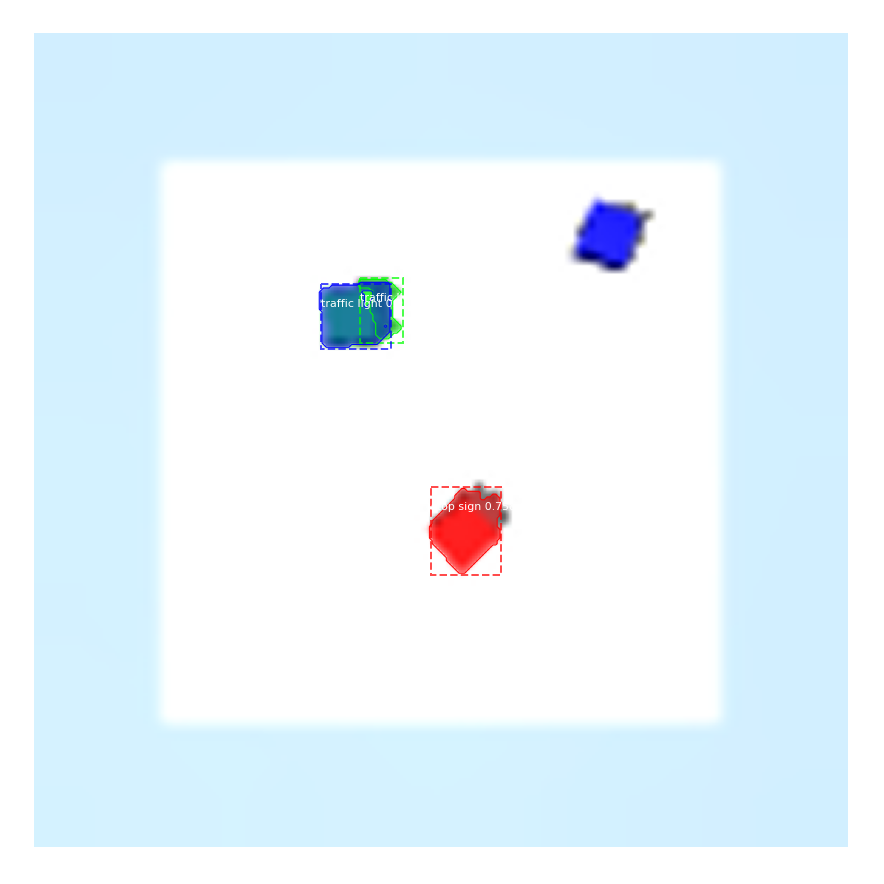

In [42]:
import cv2

# Load a random image from the images folder
image2 = (np.load('tim.npy') * 255).astype(np.uint8)
pad = 5
image2 = np.pad(image2[pad:-pad, pad:-pad], [[pad,pad],[pad,pad], [0, 0]], 'edge')

scale = 3
height, width = image2.shape[:2]
# im_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
im_large2 = cv2.resize(image2, (width*scale, height*scale), interpolation=cv2.INTER_CUBIC)

# Run detection
results = model.detect([im_large2], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(im_large2, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [37]:
r['scores']

array([0.9768794 , 0.9534569 , 0.75782114], dtype=float32)

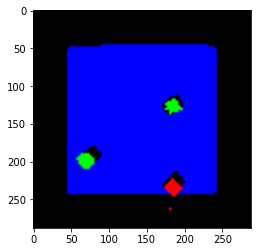

In [50]:
plt.imshow(im)

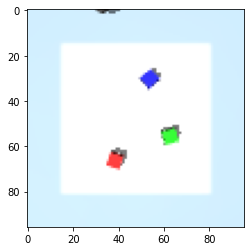

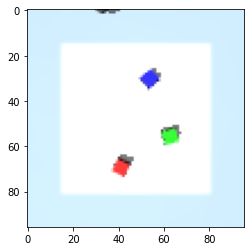

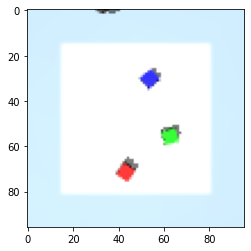

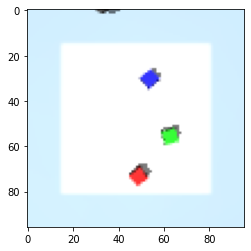

In [56]:
for fid in range(4):
    file_name = f'scenes/{fid}.npy'
    im = (np.load(file_name) * 255).astype(np.uint8)
#     im = im.transpose([1,2,0])
    plt.imshow(im)
    plt.show()

Processing 1 images
image                    shape: (288, 288, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


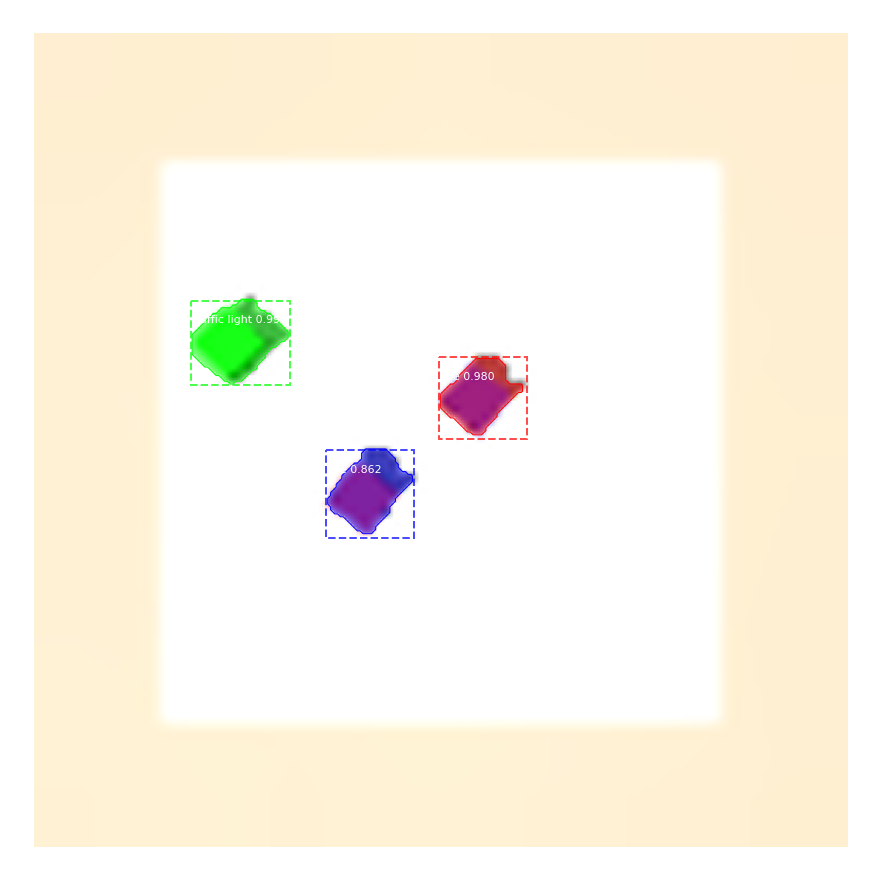

In [58]:
pad = 5
scale = 3
fid = 0
file_name = f'scenes/{fid}.npy'
im = (np.load(file_name) * 255).astype(np.uint8)
im = np.pad(im[pad:-pad, pad:-pad], [[pad,pad],[pad,pad], [0, 0]], 'edge')

height, width = im.shape[:2]
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (width*scale, height*scale), interpolation=cv2.INTER_CUBIC)

# Run detection
results = model.detect([im], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(im, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

Processing 1 images
image                    shape: (288, 288, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


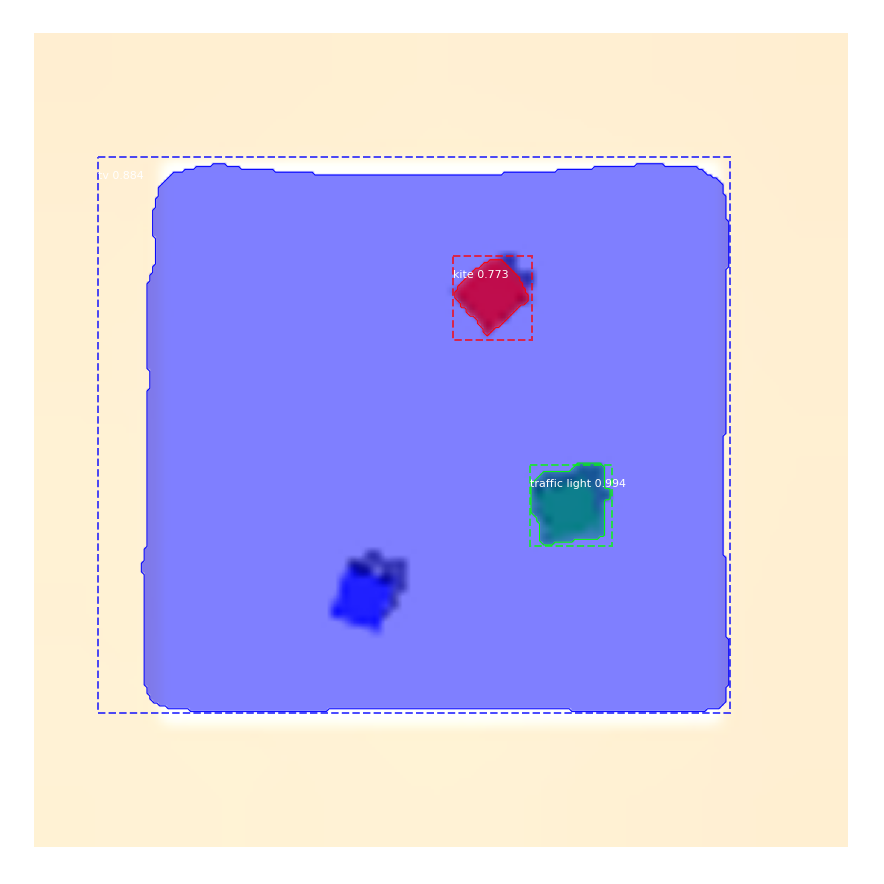

Processing 1 images
image                    shape: (288, 288, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


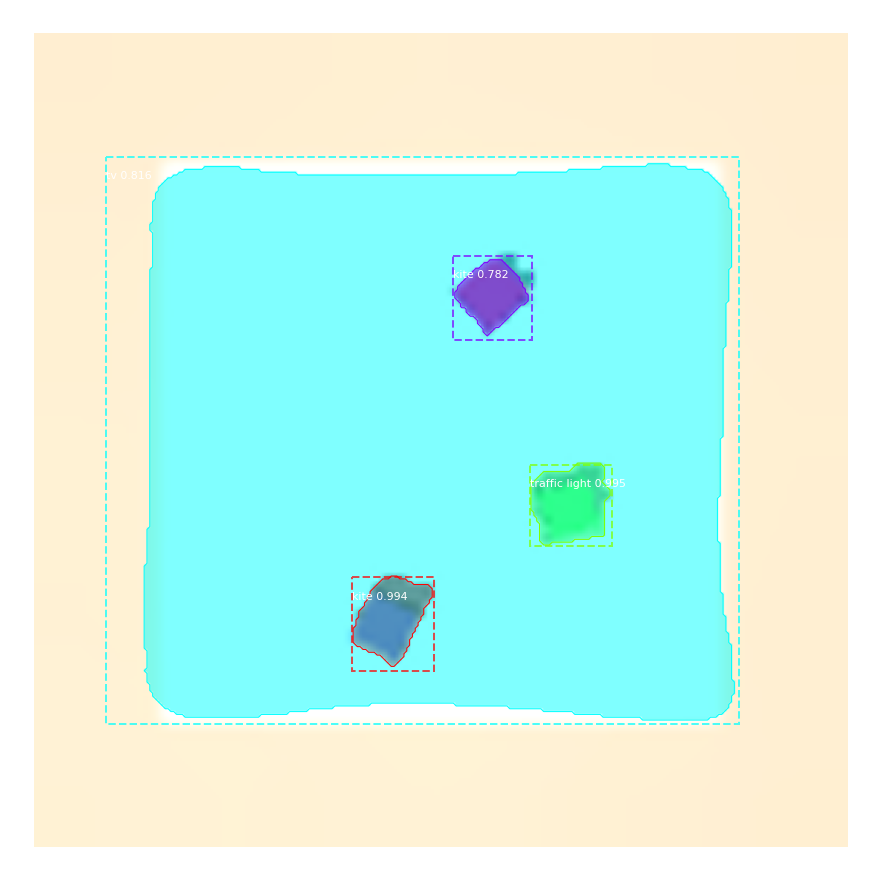

Processing 1 images
image                    shape: (288, 288, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


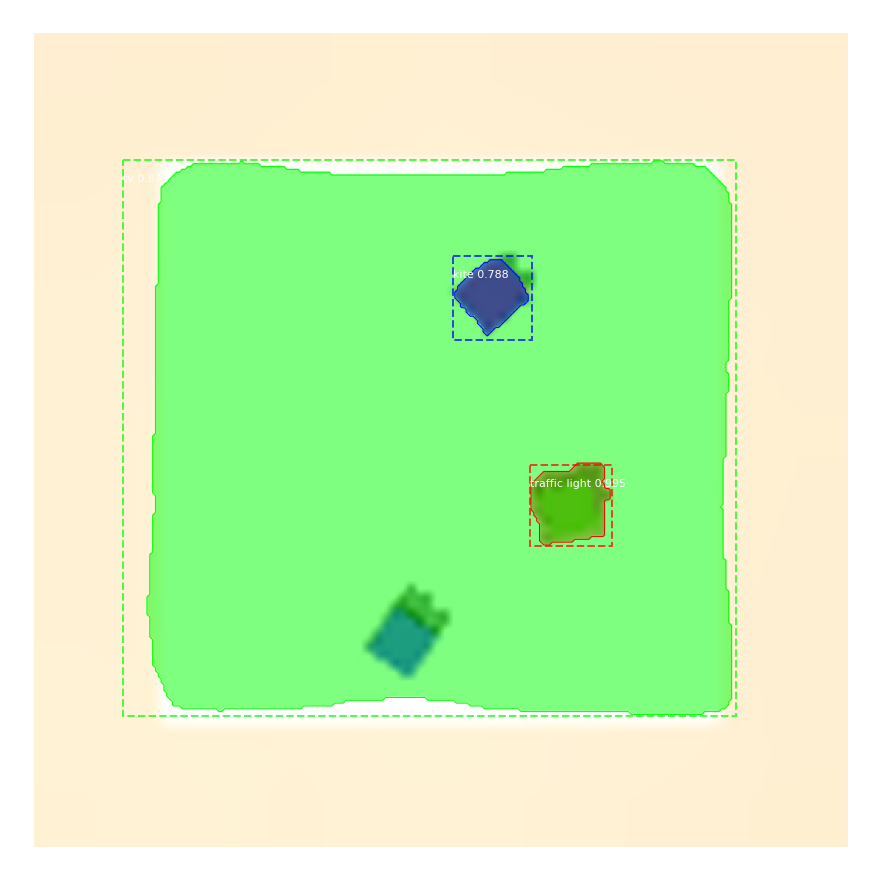

Processing 1 images
image                    shape: (288, 288, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


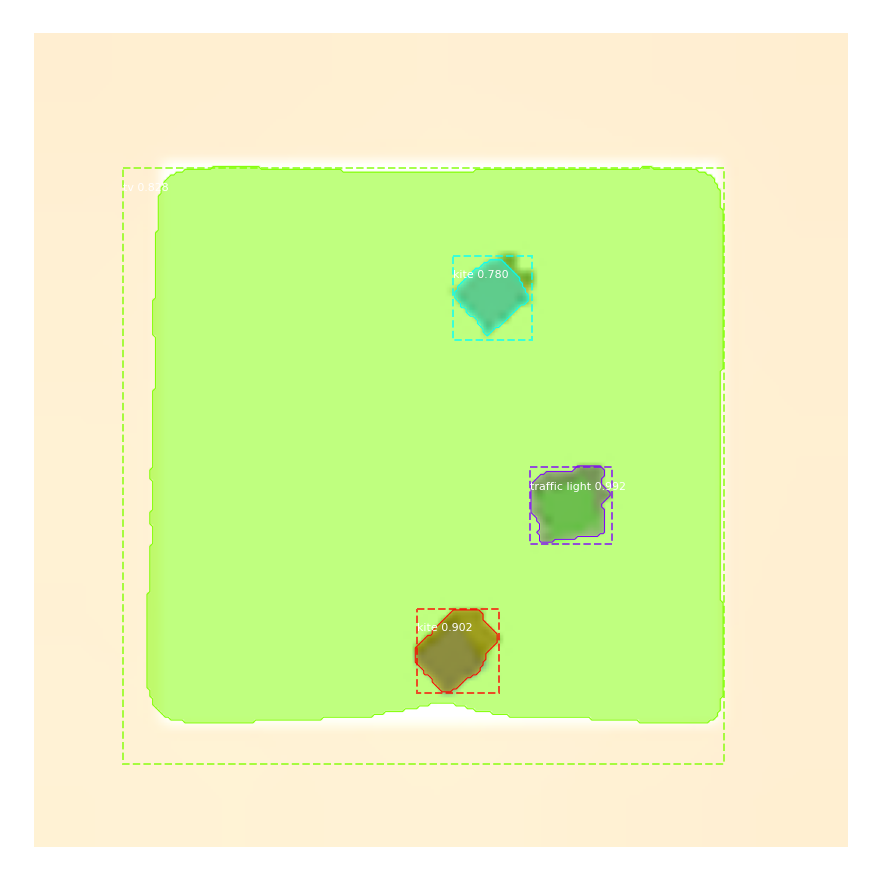

Processing 1 images
image                    shape: (288, 288, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


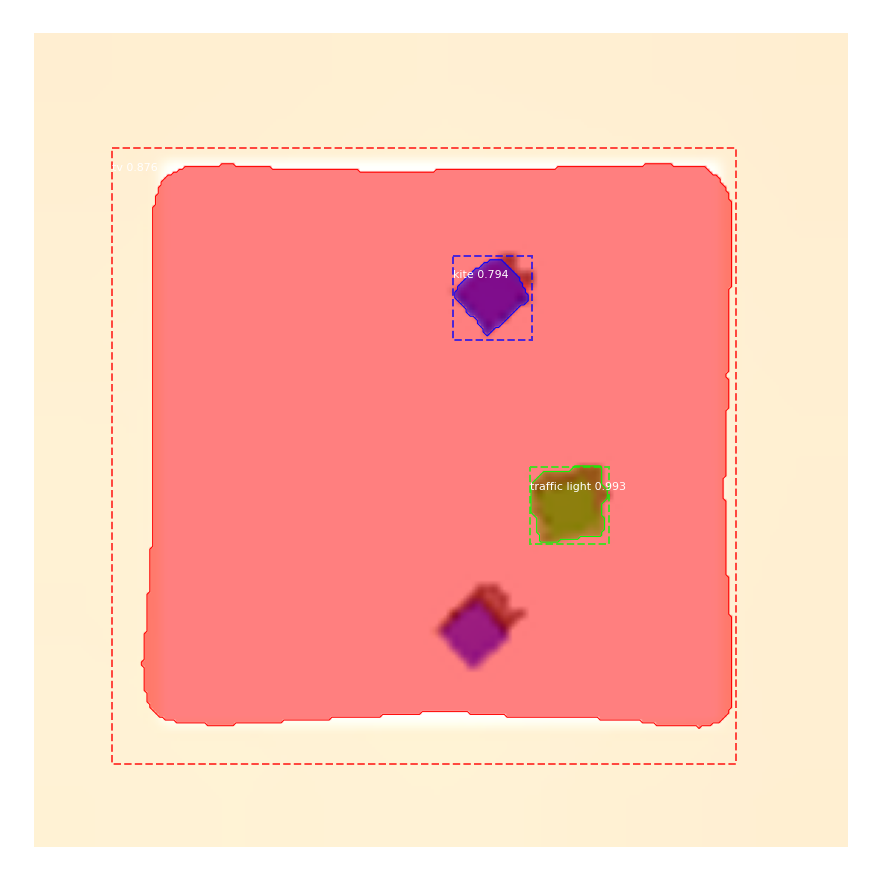

Processing 1 images
image                    shape: (288, 288, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


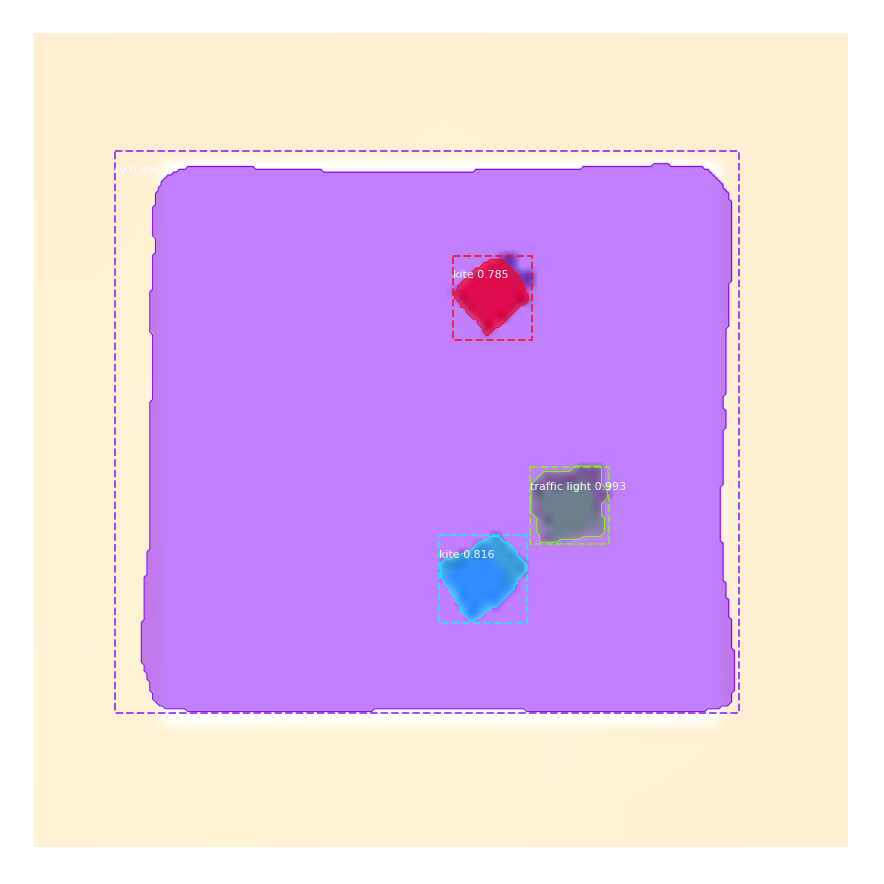

In [57]:
pad = 5
scale = 3
for fid in range(len(os.listdir('scenes'))):
    file_name = f'scenes/{fid}.npy'
    im = (np.load(file_name) * 255).astype(np.uint8)
    im = np.pad(im[pad:-pad, pad:-pad], [[pad,pad],[pad,pad], [0, 0]], 'edge')

    height, width = im.shape[:2]
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (width*scale, height*scale), interpolation=cv2.INTER_CUBIC)

    # Run detection
    results = model.detect([im], verbose=1)

    # Visualize results
    r = results[0]
    visualize.display_instances(im, r['rois'], r['masks'], r['class_ids'], 
                                class_names, r['scores'])

In [38]:
image.shape

(96, 96, 3)

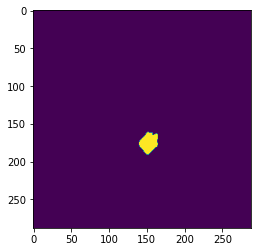

In [41]:
plt.imshow(r['masks'][:,:,2].astype(int))

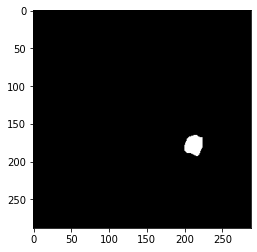

In [32]:
mask = r['masks'][:,:,1].astype(np.float32)
mask_rgb = np.concatenate([mask.flatten()] * 3).reshape(3, mask.shape[0], mask.shape[1])
mask_rgb = mask_rgb.transpose([1,2,0])
plt.imshow(mask_rgb)

In [33]:
mask_resized = cv2.resize(mask_rgb, (0, 0), fx=1/3, fy=1/3)
mask_real = mask_resized[:,:,0]

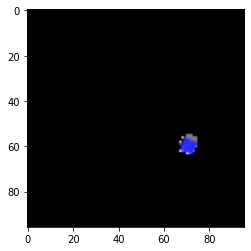

In [34]:
plt.imshow(image/255 * mask_resized)

In [37]:
mask_real.astype(bool).shape

(96, 96)

In [39]:
np.mean(image[mask_real.astype(bool)], 0)

array([ 72.29310345,  72.29310345, 209.55172414])

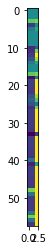

In [36]:
plt.imshow(image[mask_real.astype(bool)]/255)

In [146]:
(image/255 * mask_resized).mean(0).mean(0)

array([0.00178419, 0.00178419, 0.00517174])

In [151]:
mask_resized.astype(bool).shape

(96, 96, 3)

In [156]:
image[mask_resized[:,:,0].astype(bool)].mean(0)/255

array([0.28350237, 0.28350237, 0.82177147])

In [136]:
im_small = cv2.resize(im_large, (0, 0), fx=1/3, fy=1/3)

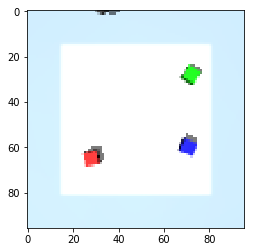

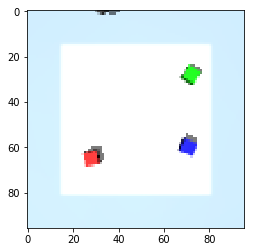

In [137]:
plt.imshow(im_small)
plt.show()
plt.imshow(image)
plt.show()

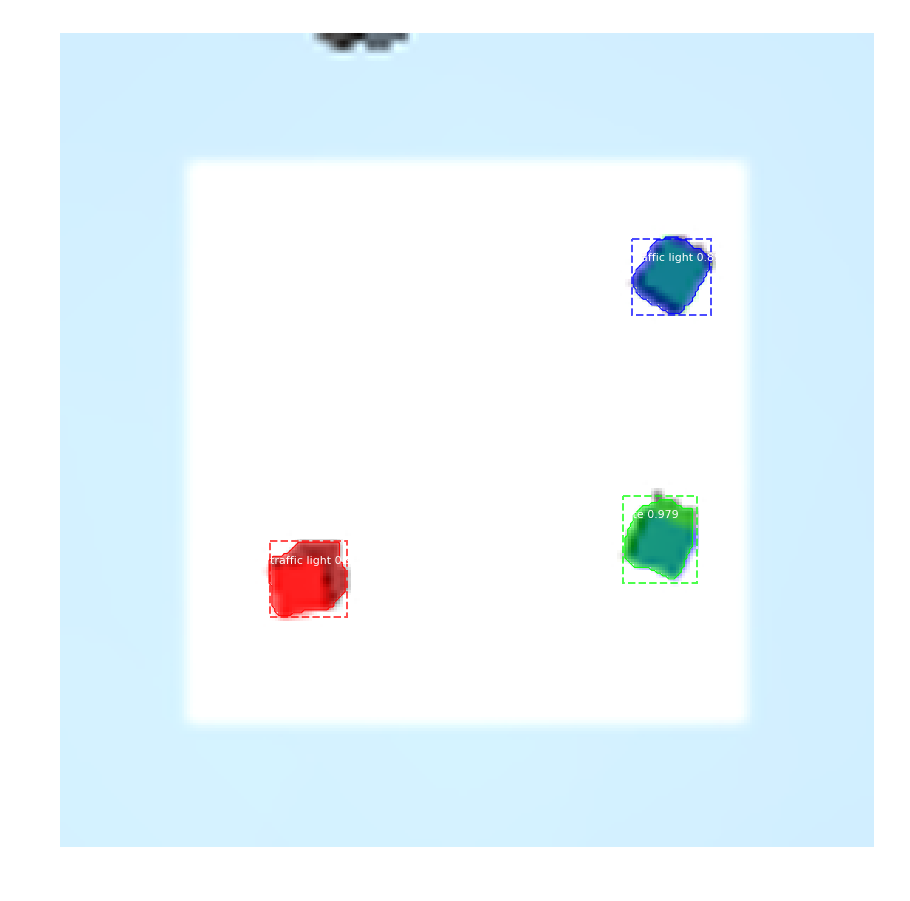

In [44]:
image = im_large
boxes = r['rois']
masks = r['masks']
class_ids = r['class_ids']
scores = r['scores']
title = ""
figsize = (16, 16)
ax = None
show_mask = True
show_bbox = True
colors = None
captions = None
"""
boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
masks: [height, width, num_instances]
class_ids: [num_instances]
class_names: list of class names of the dataset
scores: (optional) confidence scores for each box
title: (optional) Figure title
show_mask, show_bbox: To show masks and bounding boxes or not
figsize: (optional) the size of the image
colors: (optional) An array or colors to use with each object
captions: (optional) A list of strings to use as captions for each object
"""
# Number of instances
N = boxes.shape[0]
if not N:
    print("\n*** No instances to display *** \n")
else:
    assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

# If no axis is passed, create one and automatically call show()
auto_show = False
if not ax:
    _, ax = plt.subplots(1, figsize=figsize)
    auto_show = True

# Generate random colors
colors = colors or random_colors(N)

# Show area outside image boundaries.
height, width = image.shape[:2]
ax.set_ylim(height + 10, -10)
ax.set_xlim(-10, width + 10)
ax.axis('off')
ax.set_title(title)

masked_image = image.astype(np.uint32).copy()
for i in range(N):
    color = colors[i]

    # Bounding box
    if not np.any(boxes[i]):
        # Skip this instance. Has no bbox. Likely lost in image cropping.
        continue
    y1, x1, y2, x2 = boxes[i]
    if show_bbox:
        p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                            alpha=0.7, linestyle="dashed",
                            edgecolor=color, facecolor='none')
        ax.add_patch(p)

    # Label
    if not captions:
        class_id = class_ids[i]
        score = scores[i] if scores is not None else None
        label = class_names[class_id]
        caption = "{} {:.3f}".format(label, score) if score else label
    else:
        caption = captions[i]
    ax.text(x1, y1 + 8, caption,
            color='w', size=11, backgroundcolor="none")

    # Mask
    mask = masks[:, :, i]
    if show_mask:
        masked_image = apply_mask(masked_image, mask, color)

    # Mask Polygon
    # Pad to ensure proper polygons for masks that touch image edges.
    padded_mask = np.zeros(
        (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
    padded_mask[1:-1, 1:-1] = mask
    contours = find_contours(padded_mask, 0.5)
    for verts in contours:
        # Subtract the padding and flip (y, x) to (x, y)
        verts = np.fliplr(verts) - 1
        p = Polygon(verts, facecolor="none", edgecolor=color)
        ax.add_patch(p)
ax.imshow(masked_image.astype(np.uint8))
if auto_show:
    plt.show()


In [43]:
from mrcnn.visualize import random_colors, apply_mask
from matplotlib import patches
from skimage.measure import find_contours
from matplotlib.patches import Polygon

ValueError: operands could not be broadcast together with shapes (96,96) (288,288) (288,288) 

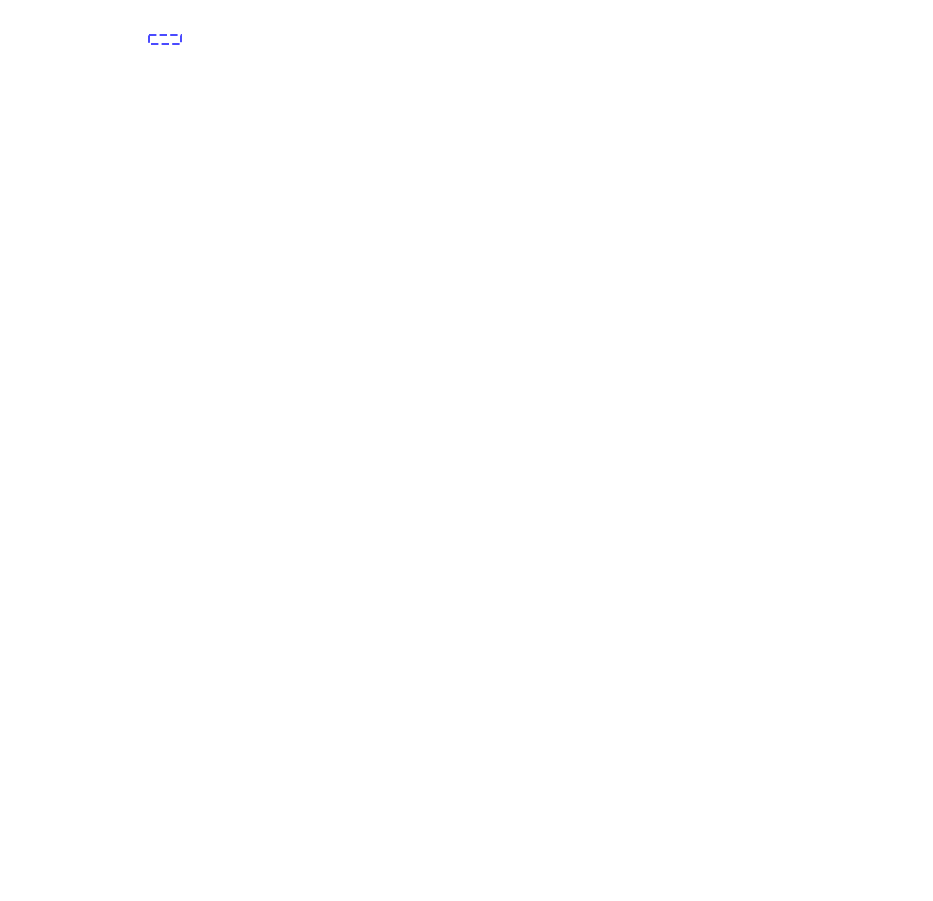

In [59]:
image = im_large
boxes = r['rois']
masks = r['masks']
class_ids = r['class_ids']
scores = r['scores']
title = ""
figsize = (16, 16)
ax = None
show_mask = True
show_bbox = True
colors = None
captions = None
"""
boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
masks: [height, width, num_instances]
class_ids: [num_instances]
class_names: list of class names of the dataset
scores: (optional) confidence scores for each box
title: (optional) Figure title
show_mask, show_bbox: To show masks and bounding boxes or not
figsize: (optional) the size of the image
colors: (optional) An array or colors to use with each object
captions: (optional) A list of strings to use as captions for each object
"""
# Number of instances
N = boxes.shape[0]
if not N:
    print("\n*** No instances to display *** \n")
else:
    assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

# If no axis is passed, create one and automatically call show()
auto_show = False
if not ax:
    _, ax = plt.subplots(1, figsize=figsize)
    auto_show = True

# Generate random colors
colors = colors or random_colors(N)

# Show area outside image boundaries.
height, width = image.shape[:2]
ax.set_ylim(height + 10, -10)
ax.set_xlim(-10, width + 10)
ax.axis('off')
ax.set_title(title)

masked_image = image.astype(np.uint32).copy()
i = 2

color = colors[i]

# Bounding box
if np.any(boxes[i]):
    y1, x1, y2, x2 = boxes[i]
    if show_bbox:
        p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                            alpha=0.7, linestyle="dashed",
                            edgecolor=color, facecolor='none')
        ax.add_patch(p)

    # Label
    if not captions:
        class_id = class_ids[i]
        score = scores[i] if scores is not None else None
        label = class_names[class_id]
        caption = "{} {:.3f}".format(label, score) if score else label
    else:
        caption = captions[i]
    ax.text(x1, y1 + 8, caption,
            color='w', size=11, backgroundcolor="none")

    # Mask
    mask = masks[:, :, i]
    if show_mask:
        masked_image = apply_mask(masked_image, mask, color)

    # Mask Polygon
    # Pad to ensure proper polygons for masks that touch image edges.
    padded_mask = np.zeros(
        (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
    padded_mask[1:-1, 1:-1] = mask
    contours = find_contours(padded_mask, 0.5)
    for verts in contours:
        # Subtract the padding and flip (y, x) to (x, y)
        verts = np.fliplr(verts) - 1
        p = Polygon(verts, facecolor="none", edgecolor=color)
        ax.add_patch(p)
ax.imshow(masked_image.astype(np.uint8))
if auto_show:
    plt.show()


In [50]:
len(contours)

1

ValueError: Invalid RGBA argument: [(0.0, 1.0, 0.0)]

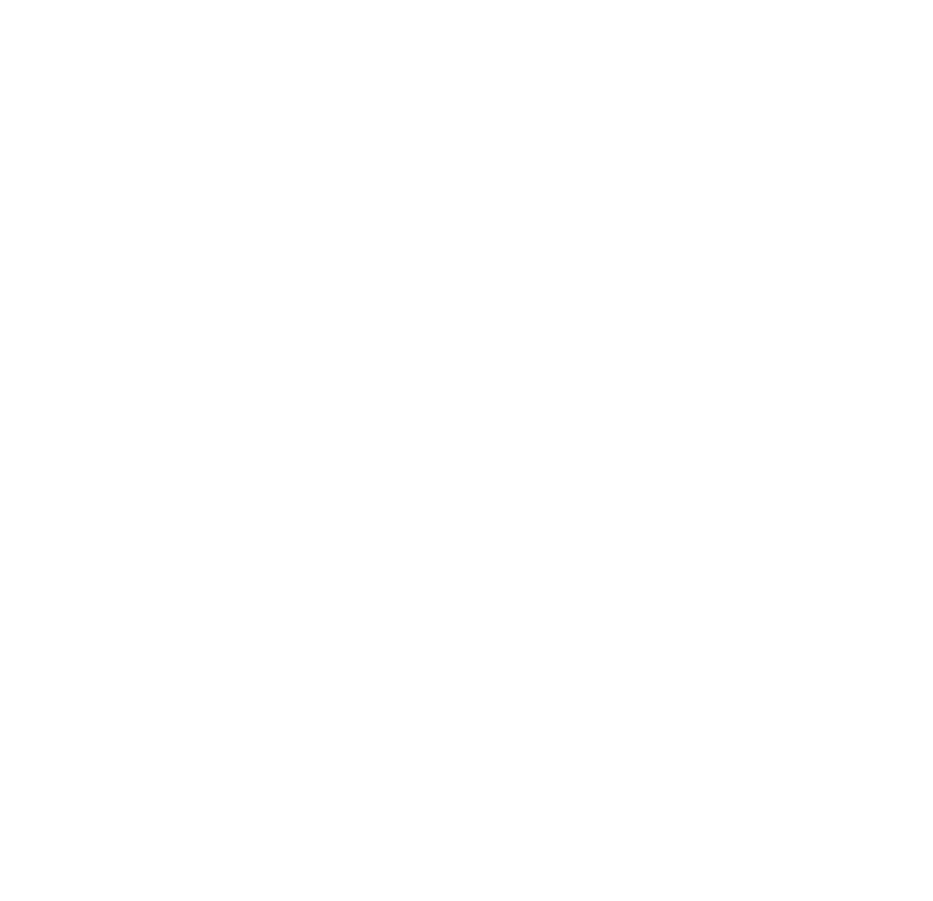

In [35]:
image = im_large
boxes = r['rois']
masks = r['masks']
class_ids = r['class_ids']
scores = r['scores']
title = ""
figsize = (16, 16)
ax = None
show_mask = True
show_bbox = True
colors = None
captions = None
"""
boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
masks: [height, width, num_instances]
class_ids: [num_instances]
class_names: list of class names of the dataset
scores: (optional) confidence scores for each box
title: (optional) Figure title
show_mask, show_bbox: To show masks and bounding boxes or not
figsize: (optional) the size of the image
colors: (optional) An array or colors to use with each object
captions: (optional) A list of strings to use as captions for each object
"""
# Number of instances
N = boxes.shape[0]
if not N:
    print("\n*** No instances to display *** \n")
else:
    assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

# If no axis is passed, create one and automatically call show()
auto_show = False
if not ax:
    _, ax = plt.subplots(1, figsize=figsize)
    auto_show = True

# Generate random colors
colors = colors or random_colors(N)

# Show area outside image boundaries.
height, width = image.shape[:2]
ax.set_ylim(height + 10, -10)
ax.set_xlim(-10, width + 10)
ax.axis('off')
ax.set_title(title)

masked_image = image.astype(np.uint32).copy()
i = 0

color = [colors[i]]

# Bounding box
if np.any(boxes[i]):
    y1, x1, y2, x2 = boxes[i]
    if show_bbox:
        p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                            alpha=0.7, linestyle="dashed",
                            edgecolor=color, facecolor='none')
        ax.add_patch(p)

    # Label
    if not captions:
        class_id = class_ids[i]
        score = scores[i] if scores is not None else None
        label = class_names[class_id]
        caption = "{} {:.3f}".format(label, score) if score else label
    else:
        caption = captions[i]
    ax.text(x1, y1 + 8, caption,
            color='w', size=11, backgroundcolor="none")

    # Mask
    mask = masks[:, :, i]
    if show_mask:
        masked_image = apply_mask(masked_image, mask, color)

    # Mask Polygon
    # Pad to ensure proper polygons for masks that touch image edges.
    padded_mask = np.zeros(
        (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
    padded_mask[1:-1, 1:-1] = mask
    contours = find_contours(padded_mask, 0.5)
    for verts in contours:
        # Subtract the padding and flip (y, x) to (x, y)
        verts = np.fliplr(verts) - 1
        p = Polygon(verts, facecolor="none", edgecolor=color)
        ax.add_patch(p)

ax.imshow(masked_image.astype(np.uint8))
if auto_show:
    plt.show()


In [15]:
r['scores']

array([0.9974485 , 0.98773044, 0.9789988 , 0.9712307 , 0.94256616,
       0.9032997 , 0.74783206, 0.72555536], dtype=float32)

In [21]:
r['rois']

array([[208, 267, 290, 348],
       [146, 171, 237, 235],
       [ 32,   0, 464, 620],
       [ 42, 251, 157, 316],
       [ 96, 308, 159, 422],
       [309, 167, 438, 304],
       [229, 152, 297, 195],
       [315, 358, 432, 484]], dtype=int32)

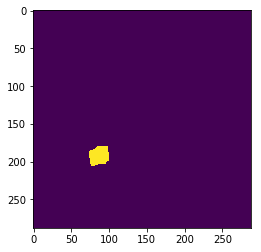

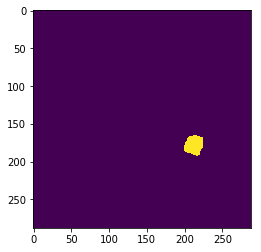

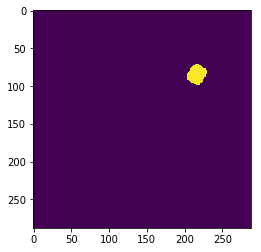

In [53]:
mask_sum = None
for i in range(r['masks'].shape[-1]):
    if mask_sum is None:
        mask_num = r
    plt.imshow(r['masks'][:,:,i])
    plt.show()

Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


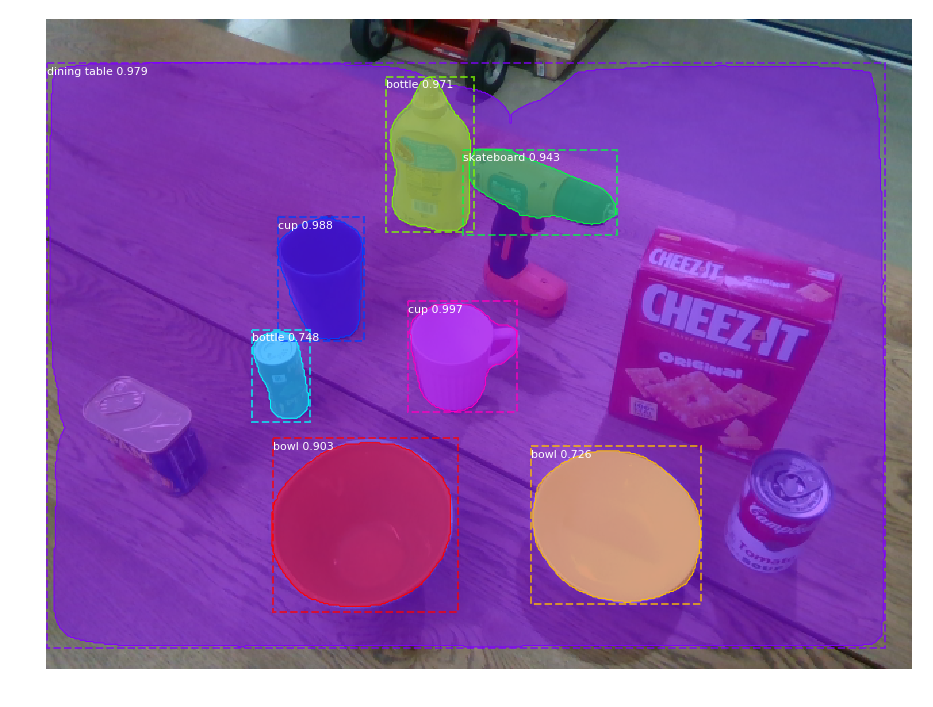

In [9]:
# Load a random image from the images folder
image = skimage.io.imread('../../t0.png')

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])